<a href="https://colab.research.google.com/github/ReidelVichot/DSTEP23/blob/main/week_6/dstep23_dsny_trash_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **DSTEP23 // Dept of Sanitation in NYC, Part 3: uniform and non-uniform sampling**

*October 3, 2023*

This notebook will explore two questions related to waste removal by New York City's Department of Sanitation:

- ***What is the relationship between refuse and recycling?***

- ***Is there periodicity in the tonnage data?***

The data can be found [here](https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5).

---

### **From Part 1**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

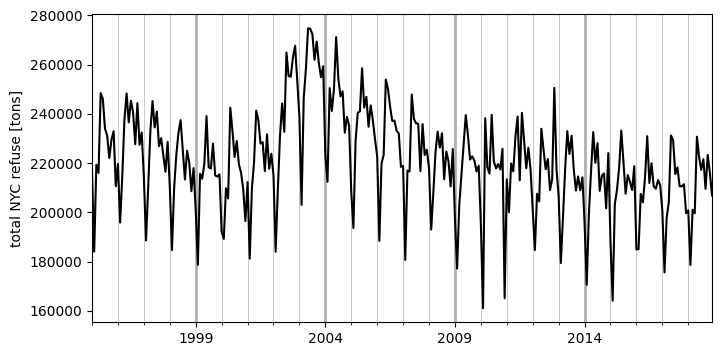

In [2]:
# -- set the filename and read the data while parsing the MONTH column
fname = "https://data.cityofnewyork.us/api/views/ebb7-mvp5/rows.csv?accessType=DOWNLOAD"
dsny  = pd.read_csv(fname, parse_dates=["MONTH"])

# -- sub-select only the first six columns
cols = dsny.columns[:6]
dsny = dsny[cols]

# -- rename the columns for ease of use
dsny.columns = ["month", "borough", "district", "refuse", "paper", "mgp"]

# -- create a column that is all recycling
dsny["recy"] = dsny["paper"] + dsny["mgp"]

# -- sort by month values
dsny = dsny.sort_values("month", ignore_index=True)

# -- let's concentrate on 1995 to 2019 (16 years)
ind_tlo = dsny["month"] >= "1995-01-01"
ind_thi = dsny["month"] < "2019-01-01"
ind_tot = ind_tlo & ind_thi
dsny = dsny[ind_tot]

# -- convert NaNs to 0s
dsny = dsny.fillna(0.0)

# -- group by month and sum to aggregate across the whole city
nyc_ts = dsny.groupby("month").sum(numeric_only=True)

# -- visualize
fig, ax = plt.subplots(figsize=(8, 4))
nyc_ts.plot(y="refuse", ylabel="total NYC refuse [tons]", xlabel="", legend=False, color="k", ax=ax)
ax.grid(axis="x", which="major", lw=2)
ax.grid(axis="x", which="minor", lw=0.5)
fig.show()

### **From Part 2**


 12 month rolling average correlation
           refuse     paper       mgp      recy
refuse  1.000000 -0.401365 -0.751558 -0.773210
paper  -0.401365  1.000000  0.686164  0.752846
mgp    -0.751558  0.686164  1.000000  0.968744
recy   -0.773210  0.752846  0.968744  1.000000 



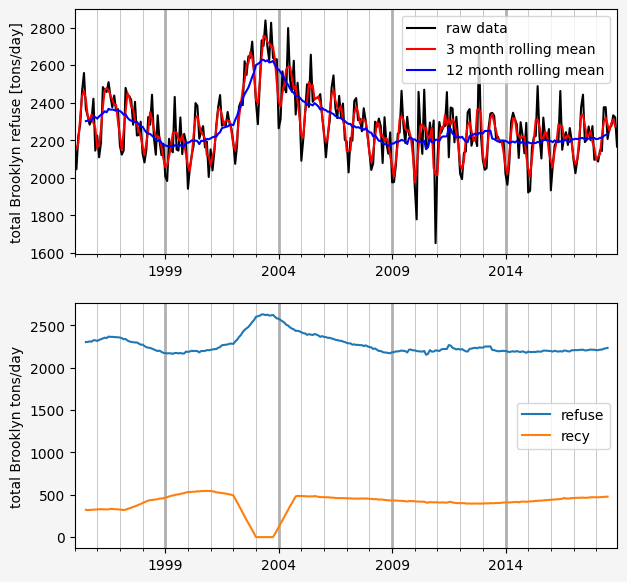

In [3]:
# -- sub-select Brooklyn
bk = dsny[dsny["borough"] == "Brooklyn"]
bk_ts = bk.groupby("month").sum(numeric_only=True)

# -- divide by days in the month
bk_ts = bk_ts.divide(bk_ts.index.days_in_month, axis=0)

# -- take the rolling mean of the Brooklyn refuse with a quarterly window
bk_ts_03 = bk_ts.rolling(3, center=True).mean()
bk_ts_12 = bk_ts.rolling(12, center=True).mean()

# -- plot the two
fig, ax = plt.subplots(2, 1, facecolor="whitesmoke", figsize=(7, 7))
bk_ts.plot(y="refuse", color="k", label="raw data", ax=ax[0])
bk_ts_03.plot(y="refuse", color="red", label="3 month rolling mean", ax=ax[0])
bk_ts_12.plot(y="refuse", color="blue", label="12 month rolling mean", ax=ax[0])
ax[0].grid(axis="x", which="major", lw=2)
ax[0].grid(axis="x", which="minor", lw=0.5)
ax[0].set_xlabel("")
ax[0].set_ylabel("total Brooklyn refuse [tons/day]")

# -- plot refuse and recycling
bk_ts_12.plot(y=["refuse", "recy"], ax=ax[1])
ax[1].grid(axis="x", which="major", lw=2)
ax[1].grid(axis="x", which="minor", lw=0.5)
ax[1].set_xlabel("")
ax[1].set_ylabel("total Brooklyn tons/day")

fig.show()

# -- calculate Pearson correlation coefficient
print("\n", "12 month rolling average correlation\n", bk_ts_12.corr(), "\n")

**<u>ANSWER TO FIRST QUESTION</u>: Refuse and Recycling are <i>anti</i>-correlated <small>(in Brooklyn)</small>.**

### **Auto-Correlation: Determining Periodicity**

We can remove the smoothed time series from the raw data to isolate the short time scale (aka "high frequency") behavior:

In [15]:
# -- isolate short time scale behavior
bk_short = bk_ts - bk_ts_12

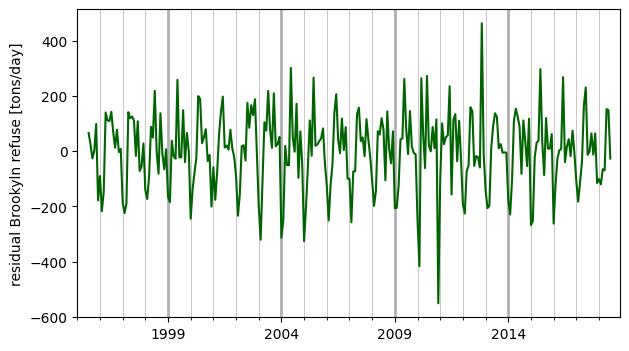

In [16]:
# -- plot the the short time scale (high frequency) behavior
fig, ax = plt.subplots(figsize=(7, 4))
bk_short.plot(y="refuse", legend=False, color="darkgreen", ax=ax)
ax.grid(axis="x", which="major", lw=2)
ax.grid(axis="x", which="minor", lw=0.5)
ax.set_xlabel("")
ax.set_ylabel("residual Brookyln refuse [tons/day]")
fig.show()

There does *seem* to be some periodicity in this time series.  We can extract that periodicity by extending the concept of correlation to <u>auto-correlation</u> which is the correlation of a time series with itself **shifted by some time lag**.

In [18]:
bk_short

,refuse,paper,mgp,recy
month,,,,
1995-01-01,NaN,NaN,NaN,NaN
1995-02-01,NaN,NaN,NaN,NaN
1995-03-01,NaN,NaN,NaN,NaN
1995-04-01,NaN,NaN,NaN,NaN
1995-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-08-01,NaN,NaN,NaN,NaN
2018-09-01,NaN,NaN,NaN,NaN
2018-10-01,NaN,NaN,NaN,NaN


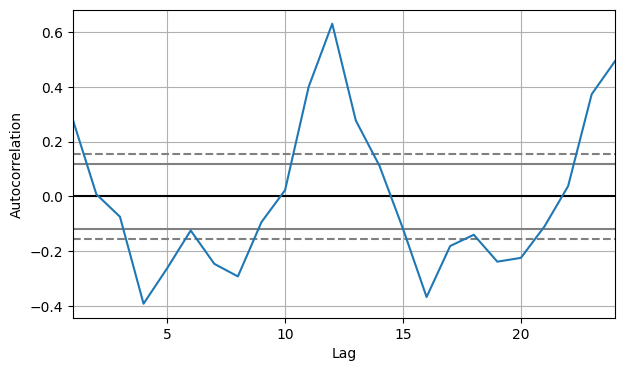

In [21]:
# -- plot autocorrelation function
fig, ax = plt.subplots(figsize=(7, 4))

pd.plotting.autocorrelation_plot(bk_short["refuse"].dropna(), ax=ax)
ax.set_xlim(1,24)
fig.show()

In [ ]:
# -- plot autocorrelation function
fig, ax = plt.subplots(figsize=(7, 4))

pd.plotting.autocorrelation_plot(bk_short["refuse"].dropna(), ax=ax)

fig.show()

**<u>ANSWER TO SECOND QUESTION</u>: Refuse has periodicity on annual time scales <small>(in Brooklyn)</small>.**

We can use some of the `statsmodels` functionality to extract the trends and seasonality (note, this is a *very* simple and basic model),

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
# -- use statsmodels to decompose the time series
res_mul = seasonal_decompose(bk_ts["refuse"], model="mul")

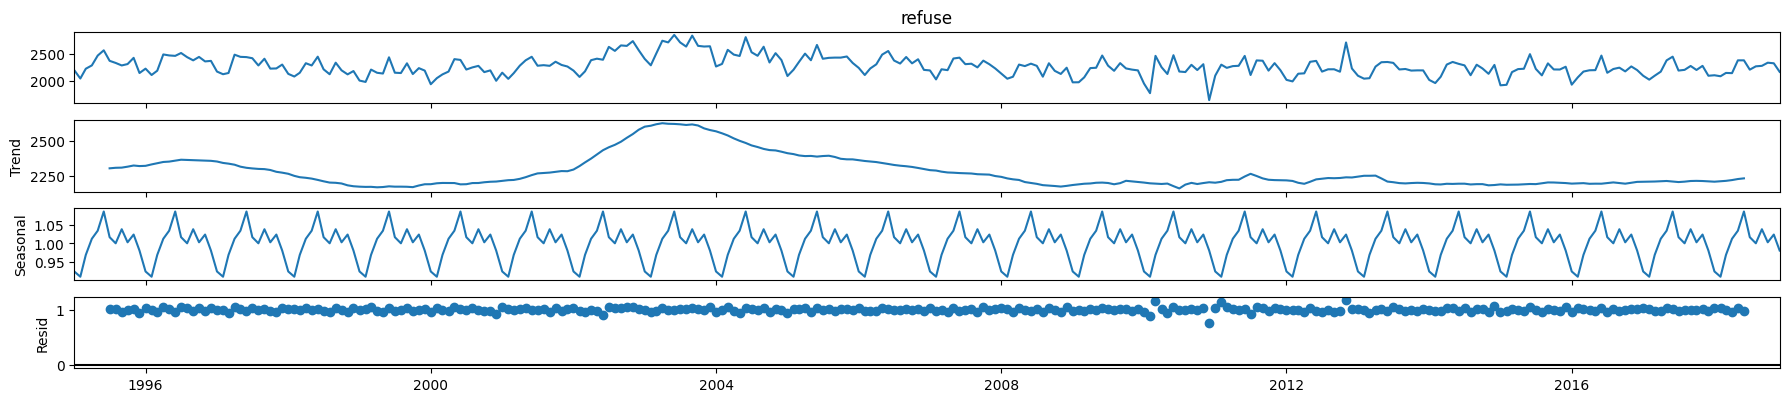

In [26]:
# -- plot the decomposition
fig = res_mul.plot()
fig.set_size_inches(20, 4)

(0.8, 1.2)

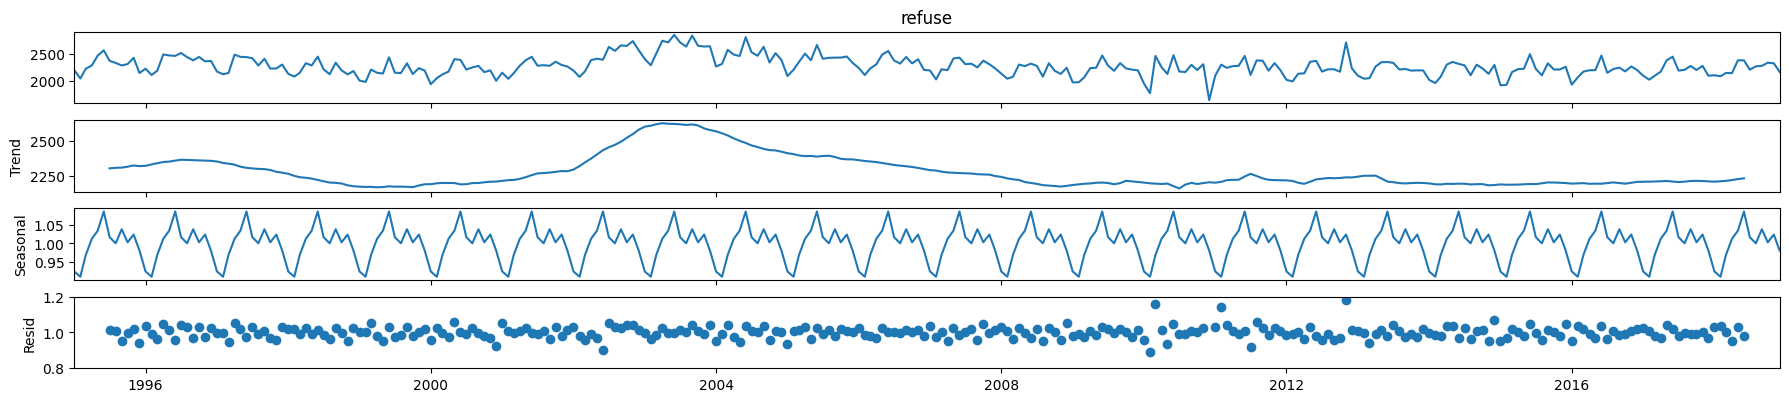

In [27]:
# -- plot the decomposition
fig = res_mul.plot()
fig.set_size_inches(20, 4)
fig.axes[3].set_ylim(0.8, 1.2)

---

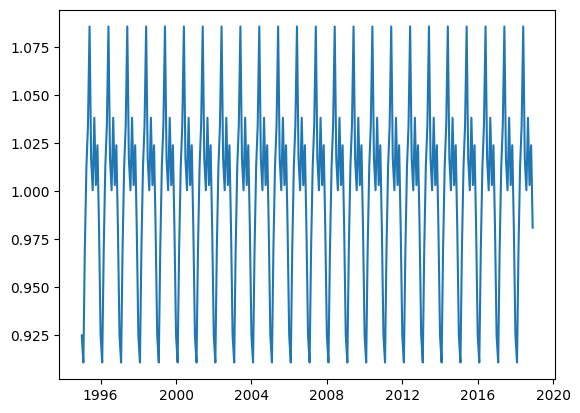

In [28]:
plt.plot(res_mul.seasonal)

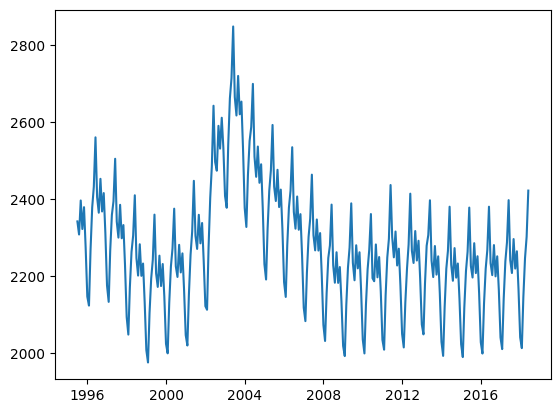

In [30]:
model = res_mul.trend * res_mul.seasonal
plt.plot(model)

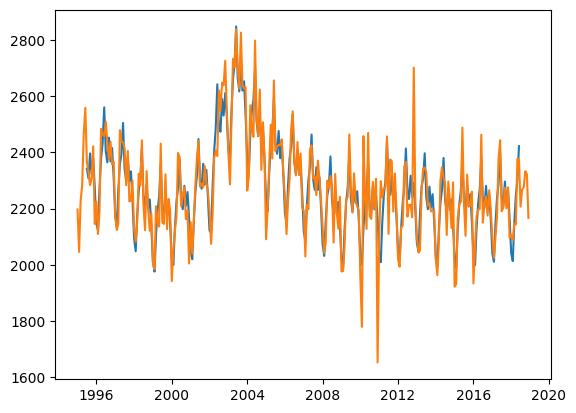

In [31]:
plt.plot(model)
plt.plot(res_mul.observed)

In [32]:
resid = res_mul.observed/ model

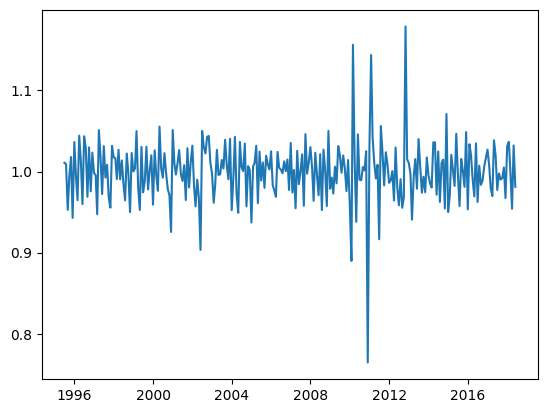

In [33]:
plt.plot(resid)

### **NON-UNIFORMLY SAMPLED DATA**

So far, we've mostly looked at "**uniformly sampled**" time series data (e.g., percentage of alternative and nuclear energy sources for various countries over time, CSIRO sea level, and DSNY waste pickups).  We've also seen one example of **non-uniformly sampled** time series data: the NOAA sea levels.

The above analyses rely on uniform sampling:

In [34]:
# -- get a random sample from our BK time series
#    (note, this "sample" is a different, but related, concept)
sub = bk_ts.sample(n=100, random_state=302).sort_index()

In [35]:
sub

,refuse,paper,mgp,recy
month,,,,
1995-04-01,2283.860000,166.120000,142.893333,309.013333
1995-07-01,2367.432258,178.703226,154.458065,333.161290
1996-01-01,2224.938710,142.912903,118.822581,261.735484
1996-04-01,2483.563333,191.530000,154.276667,345.806667
1996-06-01,2457.573333,198.490000,156.560000,355.050000
...,...,...,...,...
2017-03-01,2096.325806,234.351613,207.958065,442.309677
2017-10-01,2201.054839,233.200000,211.190323,444.390323
2018-08-01,2267.080645,246.703226,229.135484,475.838710


In [37]:
bk_ts.index.inferred_freq

'MS'

In [41]:
print(sub.index.inferred_freq)

None


In [50]:
# -- perform the seasonal decomposition
res_sub = seasonal_decompose(sub_re["refuse"], model="mul")

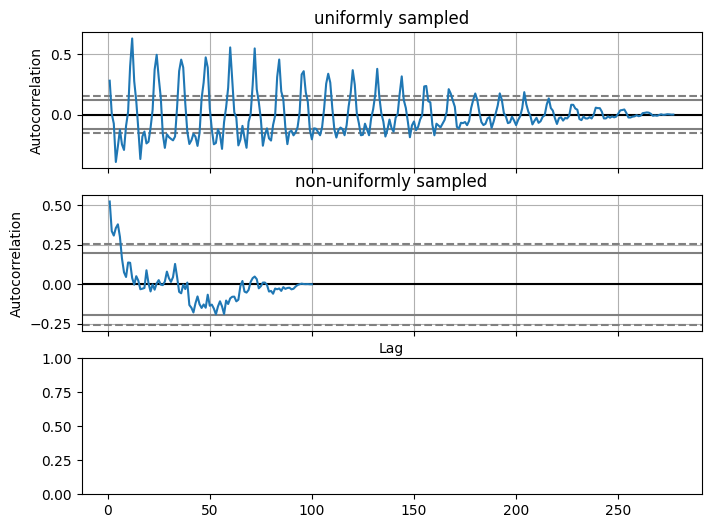

In [54]:
# -- check auto-correlation
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

pd.plotting.autocorrelation_plot(bk_short["refuse"].dropna(), ax=ax[0])
pd.plotting.autocorrelation_plot(sub["refuse"].dropna(), ax=ax[1])
#pd.plotting.autocorrelation_plot(sub_re["refuse"].dropna(), ax=ax[2])

ax[0].set_xlabel("")
ax[0].set_title("uniformly sampled")
ax[1].set_title("non-uniformly sampled")
fig.show()

`pandas` has the capability to "**re-sample**" your data via interpolation/extrapolation,

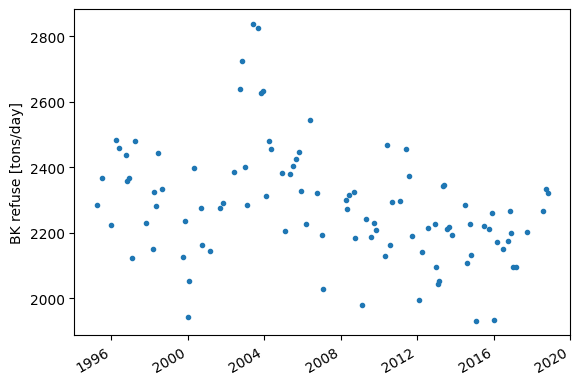

In [55]:
# -- zoom in on non-uniformly sampled data
ax = sub.plot(y="refuse", xlabel="", ylabel="BK refuse [tons/day]", legend=False, use_index=True, style=".")
xlim = ax.set_xlim("1996-01-01", "2000-01-01")

In [44]:
# -- resample the non-uniformly sampled data to uniform sampling
sub_re = sub.resample("1D").interpolate(method="linear")

In [45]:
sub_re

,refuse,paper,mgp,recy
month,,,,
1995-04-01,2283.860000,166.120000,142.893333,309.013333
1995-04-02,2284.778376,166.258277,143.020418,309.278695
1995-04-03,2285.696753,166.396554,143.147503,309.544058
1995-04-04,2286.615129,166.534832,143.274588,309.809420
1995-04-05,2287.533506,166.673109,143.401673,310.074782
...,...,...,...,...
2018-10-28,2323.994662,267.489053,233.740864,501.229917
2018-10-29,2323.656830,268.101790,233.891481,501.993271
2018-10-30,2323.318998,268.714527,234.042099,502.756625


(note, the temporal intervals for resampling can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects))

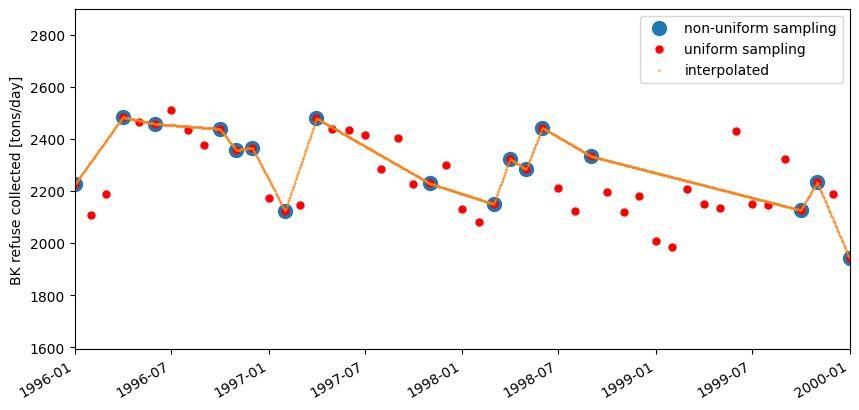

In [58]:
# -- plot the non-uniformly sampled, the uniformly sampled, and re-sampled data
fig, ax = plt.subplots(figsize=(10, 5))
sub.plot(y="refuse", use_index=True, style=".", ms=20, label="non-uniform sampling", ax=ax)
bk_ts.plot(y="refuse", use_index=True, style=".", color="r", ms=10, label="uniform sampling", ax=ax)
sub_re.plot(y="refuse", use_index=True, style=".", ms=1, label="interpolated", ax=ax)
ax.set_xlim("1996-01-01", "2000-01-01")
ax.set(xlabel="", ylabel="BK refuse collected [tons/day]")
fig.show()